In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
  # Load the dataset
df = pd.read_csv('AAPL_processed.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.head(5)

,date,open,high,low,close,adj close,volume,SMA,BB%,RSI,CCI,PPO,PPO_signal,Signal
0,2000-01-03,3.745536,4.017857,3.631696,3.997768,3.470226,133949200,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2000-01-04,3.866071,3.950893,3.613839,3.660714,3.177650,128094400,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2000-01-05,3.705357,3.948661,3.678571,3.714286,3.224152,194580400,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2000-01-06,3.790179,3.821429,3.392857,3.392857,2.945139,191993200,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2000-01-07,3.446429,3.607143,3.410714,3.553571,3.084645,115183600,NaN,NaN,NaN,NaN,NaN,NaN,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        5031 non-null   datetime64[ns]
 1   open        5031 non-null   float64       
 2   high        5031 non-null   float64       
 3   low         5031 non-null   float64       
 4   close       5031 non-null   float64       
 5   adj close   5031 non-null   float64       
 6   volume      5031 non-null   int64         
 7   SMA         5022 non-null   float64       
 8   BB%         5012 non-null   float64       
 9   RSI         5018 non-null   float64       
 10  CCI         5012 non-null   float64       
 11  PPO         5006 non-null   float64       
 12  PPO_signal  4998 non-null   float64       
 13  Signal      5031 non-null   int64         
dtypes: datetime64[ns](1), float64(11), int64(2)
memory usage: 550.4 KB


In [7]:
# Check for missing values
print(df.isnull().sum())

date           0
open           0
high           0
low            0
close          0
adj close      0
volume         0
SMA            9
BB%           19
RSI           13
CCI           19
PPO           25
PPO_signal    33
Signal         0
dtype: int64


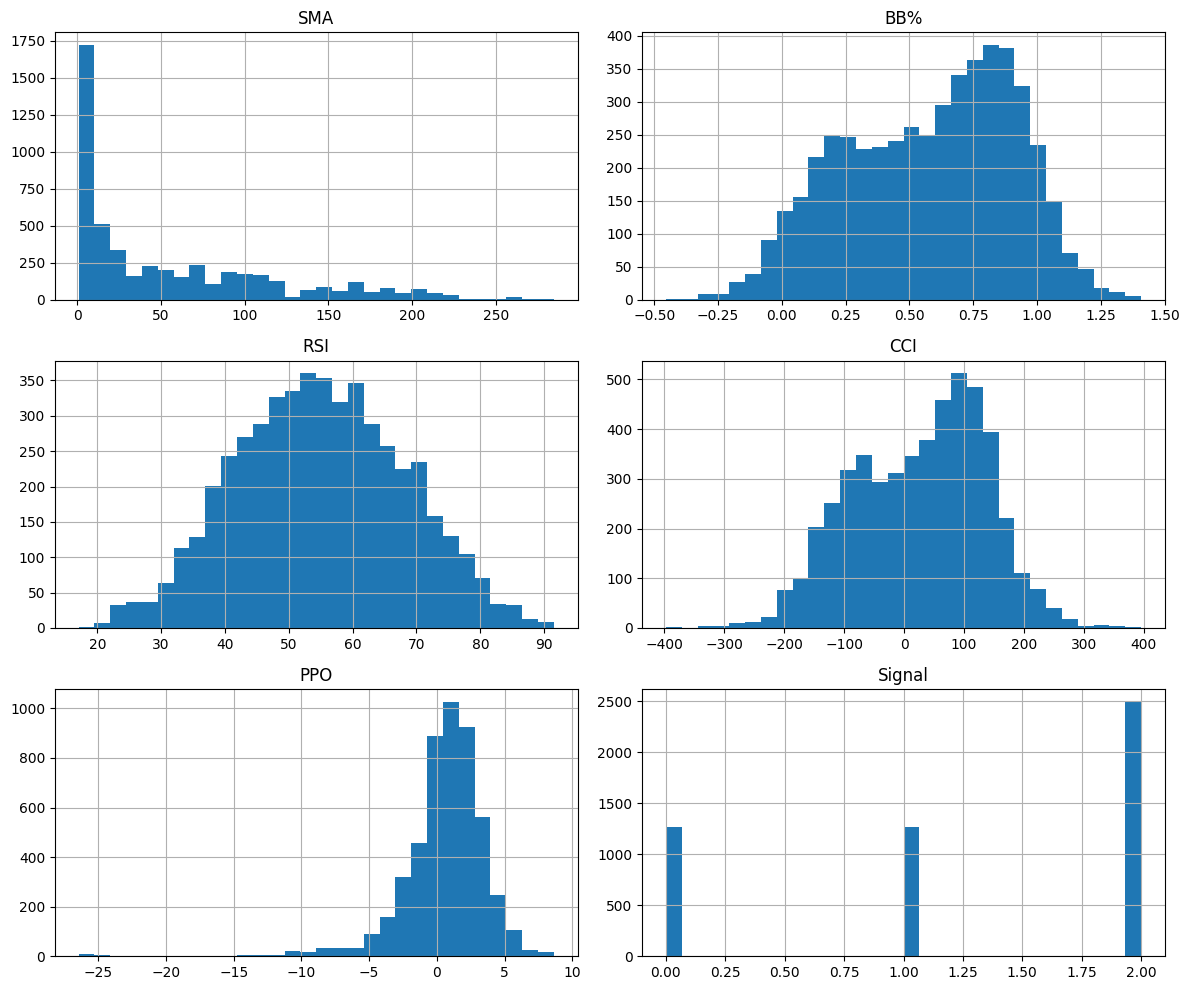

In [8]:
# Plot distribution of the features and the target
df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO', 'Signal']].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

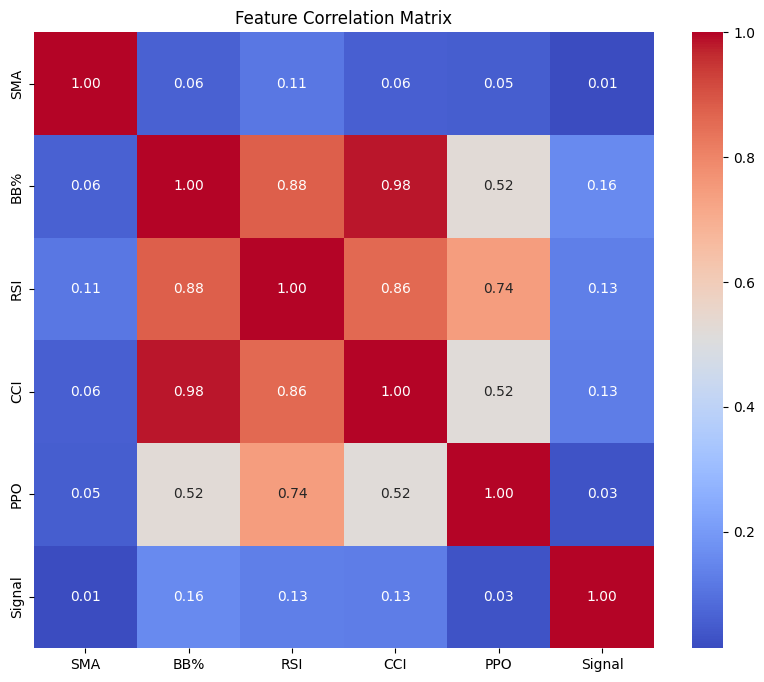

In [9]:
# Correlation matrix
correlation_matrix = df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO', 'Signal']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

In [10]:
# Check correlation with the target variable
print("Correlations with the Signal:")
print(correlation_matrix["Signal"].sort_values(ascending=False))

Correlations with the Signal:
Signal    1.000000
BB%       0.156995
RSI       0.130068
CCI       0.125979
PPO       0.032488
SMA       0.013485
Name: Signal, dtype: float64


In [11]:
# Group by year and count the records for each year
records_by_year = df.groupby(df['date'].dt.year).size()

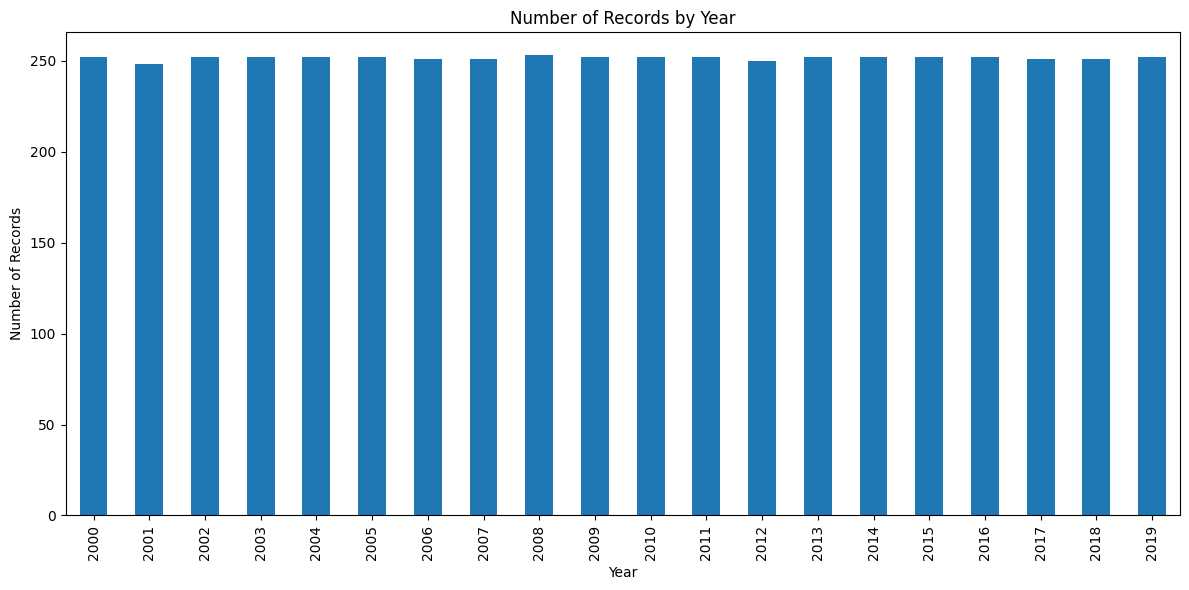

In [12]:
# Plotting the number of records by year
plt.figure(figsize=(12, 6))
records_by_year.plot(kind='bar')
plt.title('Number of Records by Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

In [13]:
# Checking label distribution in the dataset
label_distribution = df['Signal'].value_counts(normalize=True)
print("Label Distribution:")
print(label_distribution)

Label Distribution:
Signal
2    0.496323
1    0.251839
0    0.251839
Name: proportion, dtype: float64


In [14]:
# Split the data into features (X) and target (y), excluding 'adj close' and 'PPO_signal'
X = df[['SMA', 'BB%', 'RSI', 'CCI', 'PPO']]
y = df['Signal']

In [15]:
# Split the data into train and test sets
train_mask = (df['date'] < '2017-01-01')
test_mask = (df['date'] >= '2017-01-01') & (df['date'] <= '2019-12-31')

In [16]:
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

In [17]:
len(X_train), len(X_test)

(4277, 754)

In [20]:
X_train.tail()

,SMA,BB%,RSI,CCI,PPO
4272,110.446255,0.780710,65.179447,73.719384,1.336441
4273,110.823643,0.811846,67.748025,89.900721,1.372822
4274,110.973263,0.742823,64.296886,77.413350,1.350678
4275,111.120024,0.717307,64.085960,65.422140,1.315613
4276,111.120024,0.617797,57.882449,45.856730,1.210311


In [21]:
# Initialize XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [22]:
# Fit the model on the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [23]:
# Predict on the testing data
y_pred = model.predict(X_test)

In [24]:
# Evaluate the model using Mean Absolute Error
mAE = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mAE:.4f}")

Mean Absolute Error: 0.8011


In [25]:
cm_full = confusion_matrix(y_test, y_pred)

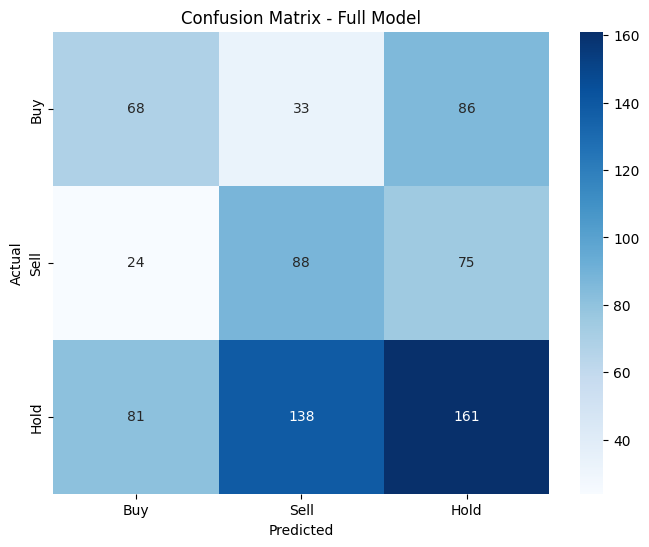

In [26]:
# Plotting the confusion matrix for the full model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', xticklabels=['Buy', 'Sell', 'Hold'], yticklabels=['Buy', 'Sell', 'Hold'])
plt.title('Confusion Matrix - Full Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [27]:
# Classification report for the full model
report_full = classification_report(y_test, y_pred, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for Full Model:")
print(report_full)

Classification Report for Full Model:
              precision    recall  f1-score   support

         Buy       0.39      0.36      0.38       187
        Sell       0.34      0.47      0.39       187
        Hold       0.50      0.42      0.46       380

    accuracy                           0.42       754
   macro avg       0.41      0.42      0.41       754
weighted avg       0.43      0.42      0.42       754



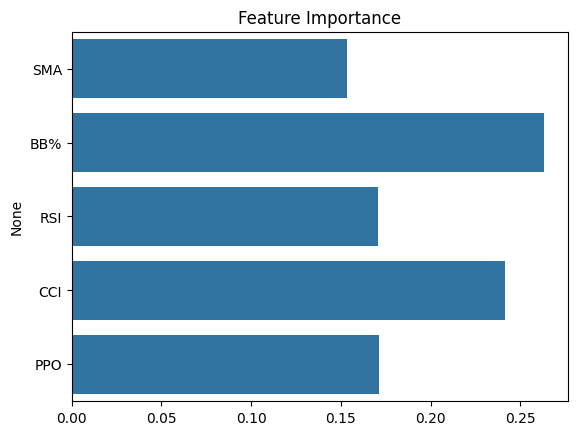

In [28]:
# Feature importance
feature_importance = model.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance')
plt.show()

In [29]:
# Split the data into reduced features (X) and target (y)
X_reduced = df[['SMA', 'BB%', 'PPO']]
y = df['Signal']

In [30]:
X_train_reduced, y_train = X_reduced[train_mask], y[train_mask]
X_test_reduced, y_test = X_reduced[test_mask], y[test_mask]

In [31]:
# Initialize XGBoost classifier
reduced_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [32]:
# Fit the reduced model on the training data
reduced_model.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [33]:
# Predict on the testing data
y_pred_reduced = reduced_model.predict(X_test_reduced)

In [34]:
# Evaluate the reduced model using Mean Absolute Error
mAE_reduced = mean_absolute_error(y_test, y_pred_reduced)
print(f"Mean Absolute Error (Reduced Model): {mAE_reduced:.4f}")

Mean Absolute Error (Reduced Model): 0.8024


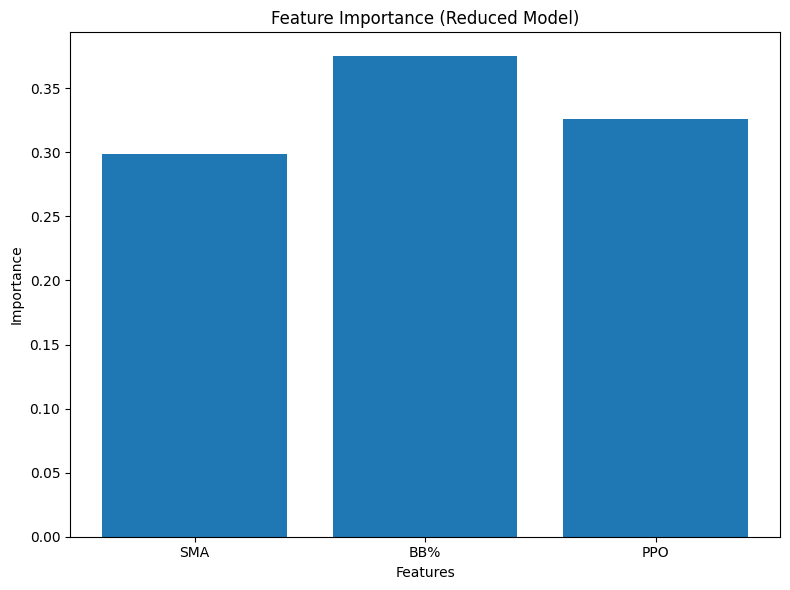

In [35]:
# Feature importance for the reduced model
feature_importance_reduced = reduced_model.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(X_reduced.columns, feature_importance_reduced)
plt.title('Feature Importance (Reduced Model)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [36]:
cm_reduced = confusion_matrix(y_test, y_pred_reduced)

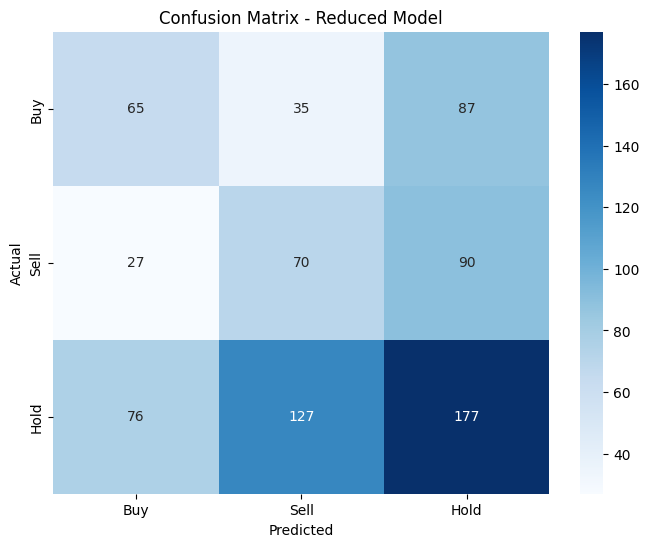

In [37]:
# Plotting the confusion matrix for the reduced model
plt.figure(figsize=(8, 6))
sns.heatmap(cm_reduced, annot=True, fmt='d', cmap='Blues', xticklabels=['Buy', 'Sell', 'Hold'], yticklabels=['Buy', 'Sell', 'Hold'])
plt.title('Confusion Matrix - Reduced Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [38]:
# Classification report for the reduced model
report_reduced = classification_report(y_test, y_pred_reduced, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for Reduced Model:")
print(report_reduced)

Classification Report for Reduced Model:
              precision    recall  f1-score   support

         Buy       0.39      0.35      0.37       187
        Sell       0.30      0.37      0.33       187
        Hold       0.50      0.47      0.48       380

    accuracy                           0.41       754
   macro avg       0.40      0.40      0.39       754
weighted avg       0.42      0.41      0.42       754



In [39]:
# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [40]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [41]:
# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)


In [42]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [43]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Best accuracy found:  0.4662219597614888


In [44]:
# Use the best estimator to make predictions
y_pred_best = grid_search.best_estimator_.predict(X_test)

In [45]:
# Calculate Mean Absolute Error
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Mean Absolute Error: {mae_best:.4f}")

Mean Absolute Error: 0.7480


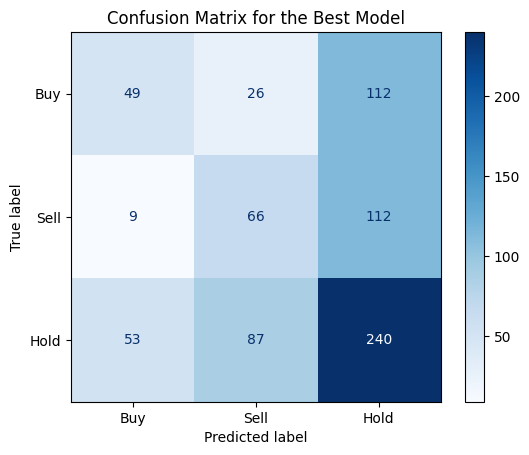

In [46]:
# Generate confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best, display_labels=['Buy', 'Sell', 'Hold']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for the Best Model')
plt.show()

<ipython-input-47-bdbde668ce27>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')


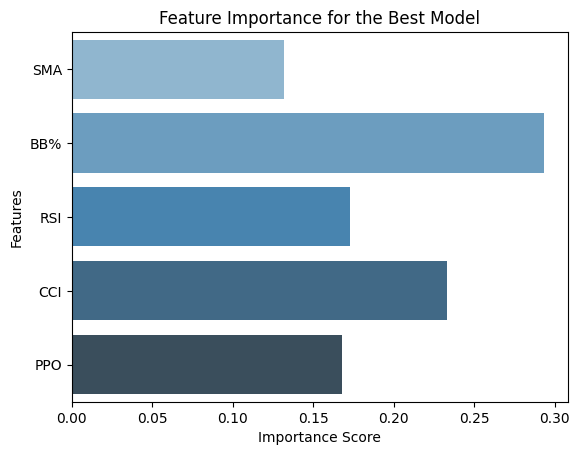

In [47]:
# Feature importance for the best model
feature_importance_best = grid_search.best_estimator_.feature_importances_
sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')
plt.title('Feature Importance for the Best Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [48]:
# Classification report for the reduced model
report_best = classification_report(y_test, y_pred_best, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for chosen Model:")
print(report_best)

Classification Report for chosen Model:
              precision    recall  f1-score   support

         Buy       0.44      0.26      0.33       187
        Sell       0.37      0.35      0.36       187
        Hold       0.52      0.63      0.57       380

    accuracy                           0.47       754
   macro avg       0.44      0.42      0.42       754
weighted avg       0.46      0.47      0.46       754



In [49]:
# Check the ratio of majority class to minority classes
class_ratio = sum(df['Signal'] == 2) / sum(df['Signal'] != 2)

In [50]:
class_ratio

0.9853985793212312

In [51]:
from sklearn.utils import class_weight

# Calculate class weights which could be 'balanced' or a dict for multi-class
class_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [52]:
# Set up the XGBClassifier without scale_pos_weight for multi-class
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [53]:
# Train the model passing the sample_weight parameter
model.fit(X_train, y_train, sample_weight=class_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [54]:
# Now continue with predictions and evaluations as before
y_pred = model.predict(X_test)

In [55]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

In [56]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

In [57]:
# Print out the mean absolute error
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.7612732095490716


In [58]:
# Print the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 86  52  49]
 [ 27 119  41]
 [ 88 180 112]]


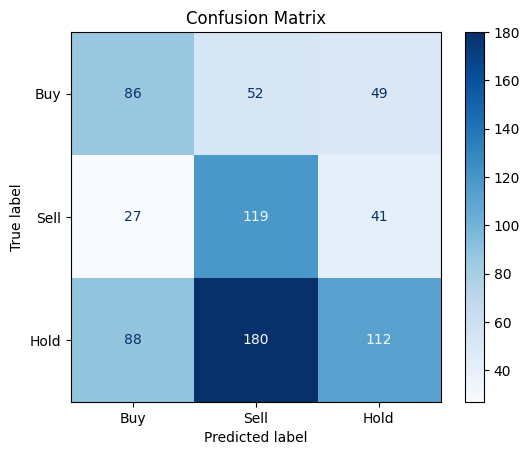

In [59]:
# Plot the confusion matrix
ConfusionMatrixDisplay(conf_matrix, display_labels=['Buy', 'Sell', 'Hold']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.46      0.44       187
           1       0.34      0.64      0.44       187
           2       0.55      0.29      0.38       380

    accuracy                           0.42       754
   macro avg       0.44      0.46      0.42       754
weighted avg       0.47      0.42      0.41       754



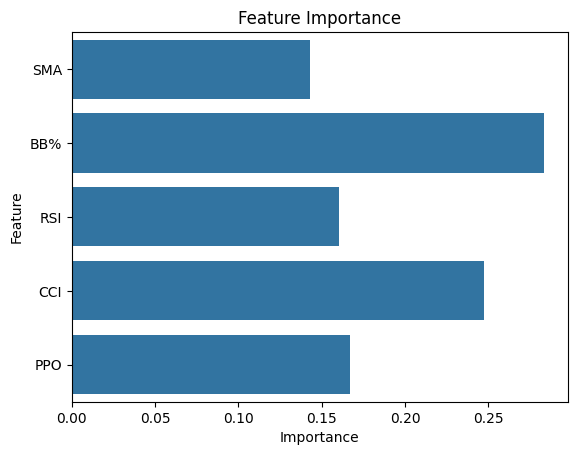

In [61]:
# Feature importance
importances = model.feature_importances_
sns.barplot(x=importances, y=X_train.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [62]:
# Apply SMOTE to oversample the minority classes in the training data
smote = SMOTE()

In [63]:
df_cleaned = df.dropna()

In [64]:
len(df_cleaned)

4998

In [65]:
# Split the data into features (X) and target (y), excluding 'adj close' and 'PPO_signal'
X_cleaned = df_cleaned[['SMA', 'BB%', 'RSI', 'CCI', 'PPO']]
y_cleaned = df_cleaned['Signal']

In [66]:
X_train_cleaned, y_train_cleaned = X_cleaned[train_mask], y_cleaned[train_mask]
X_test_cleaned, y_test_cleaned = X_cleaned[test_mask], y_cleaned[test_mask]

<ipython-input-66-bdb0391482a7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cleaned, y_train_cleaned = X_cleaned[train_mask], y_cleaned[train_mask]
<ipython-input-66-bdb0391482a7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cleaned, y_test_cleaned = X_cleaned[test_mask], y_cleaned[test_mask]


In [67]:
len(X_test_cleaned)

754

In [68]:
# Apply SMOTE to oversample the minority classes in the cleaned training data
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_cleaned, y_train_cleaned)

In [69]:
y_train_oversampled.value_counts()

Signal
0    2103
2    2103
1    2103
Name: count, dtype: int64

In [70]:
# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [71]:
# Train the model on the oversampled cleaned training data
xgb_model.fit(X_train_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [72]:
# Predict on the cleaned test data
y_pred = xgb_model.predict(X_test_cleaned)

In [73]:
# Evaluate the model on the cleaned test data
mae = mean_absolute_error(y_test_cleaned, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.7811671087533156


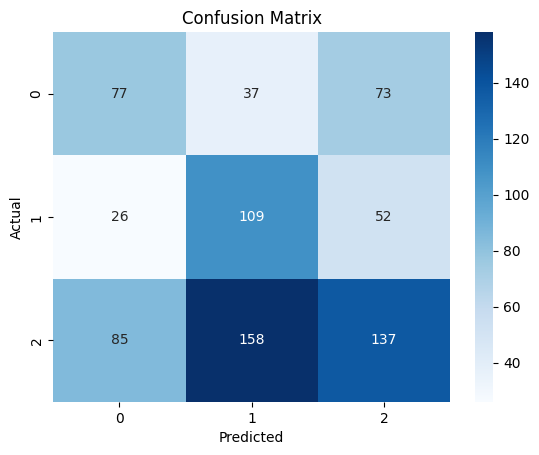

In [74]:
# Confusion matrix on the cleaned test data
confusion_mtx = confusion_matrix(y_test_cleaned, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [75]:
# Classification report on the cleaned test data
print(classification_report(y_test_cleaned, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.41      0.41       187
           1       0.36      0.58      0.44       187
           2       0.52      0.36      0.43       380

    accuracy                           0.43       754
   macro avg       0.43      0.45      0.43       754
weighted avg       0.45      0.43      0.43       754



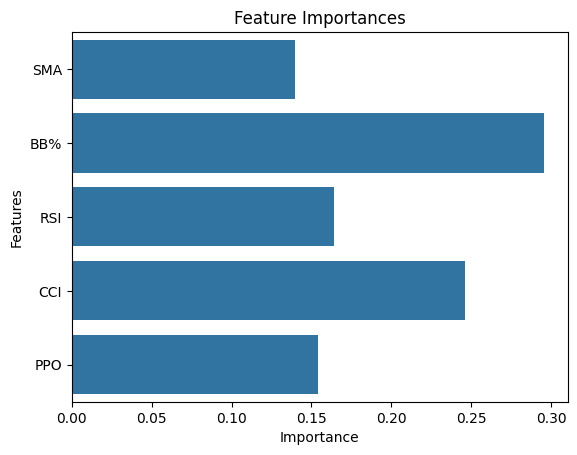

In [76]:
# Feature importance on the oversampled and cleaned training data
features = X_train_oversampled.columns
importances = xgb_model.feature_importances_
sns.barplot(x=importances, y=features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [77]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [78]:
# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1)


In [79]:
# Fit the grid search to the data
grid_search.fit(X_train_oversampled, y_train_oversampled)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [80]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.7}
Best accuracy found:  0.4737676335393881


In [81]:
# Use the best estimator to make predictions
y_pred_best = grid_search.best_estimator_.predict(X_test)

In [82]:
# Calculate Mean Absolute Error
mae_best = mean_absolute_error(y_test, y_pred_best)
print(f"Mean Absolute Error: {mae_best:.4f}")

Mean Absolute Error: 0.7944


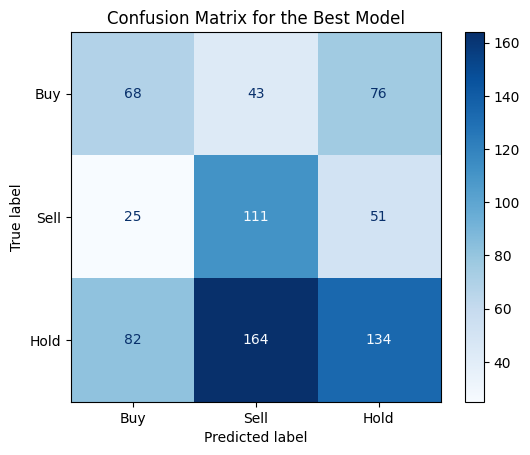

In [83]:
# Generate confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(cm_best, display_labels=['Buy', 'Sell', 'Hold']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for the Best Model')
plt.show()

<ipython-input-84-bdbde668ce27>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')


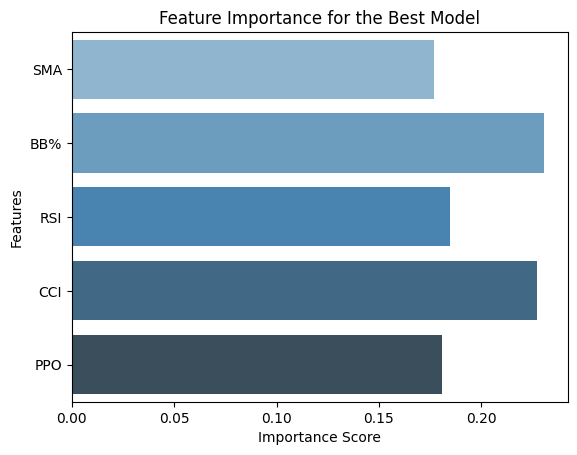

In [84]:
# Feature importance for the best model
feature_importance_best = grid_search.best_estimator_.feature_importances_
sns.barplot(x=feature_importance_best, y=X_train.columns, palette='Blues_d')
plt.title('Feature Importance for the Best Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [85]:
# Classification report for the reduced model
report_best = classification_report(y_test, y_pred_best, target_names=['Buy', 'Sell', 'Hold'])
print("Classification Report for chosen Model:")
print(report_best)

Classification Report for chosen Model:
              precision    recall  f1-score   support

         Buy       0.39      0.36      0.38       187
        Sell       0.35      0.59      0.44       187
        Hold       0.51      0.35      0.42       380

    accuracy                           0.42       754
   macro avg       0.42      0.44      0.41       754
weighted avg       0.44      0.42      0.41       754

